<a href="https://colab.research.google.com/github/CrisGiacomazzi/Medical-Cost/blob/main/Medical_Cost_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

path = kagglehub.dataset_download("mirichoi0218/insurance")

print("Path to dataset files:", path)

100%|██████████| 16.0k/16.0k [00:00<00:00, 8.09MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/mirichoi0218/insurance/versions/1


#**Libraries used in this project**

In [2]:
# Data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from scipy.stats import skew, kurtosis

#Training test
from sklearn.model_selection import train_test_split

#Model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.feature_selection import SelectFromModel

#Metrics
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
medical_cost_df = pd.read_csv(path + '/insurance.csv')

In [4]:
medical_cost_df.shape

(1338, 7)

In [5]:
medical_cost_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
medical_cost_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
medical_cost_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


*75% of customers has 51 years old and BMI 34.6 meanning obesity (NHI calcultator)

##**Data Cleaning and Preprocessing**

In [8]:
duplicate_rows = medical_cost_df[medical_cost_df.duplicated()]
print("Duplicate Rows:")
duplicate_rows

Duplicate Rows:


,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [9]:
medical_cost_df.drop_duplicates(inplace=True)

In [10]:
print(medical_cost_df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


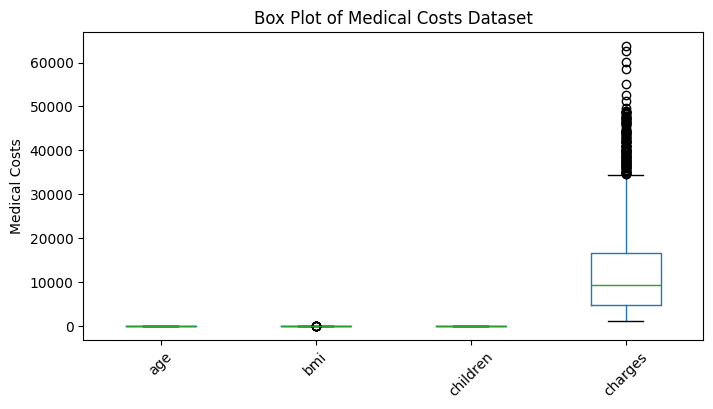

In [11]:
# Box plot for outliers visualization
plt.figure(figsize=(8, 4))
medical_cost_df.boxplot()
plt.title('Box Plot of Medical Costs Dataset')
plt.ylabel('Medical Costs')
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

In [12]:
# Identify outliers using IQR
def detect_outliers_iqr(medical_cost_df):
    Q1 = np.percentile(medical_cost_df, 25)
    Q3 = np.percentile(medical_cost_df, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = medical_cost_df[(medical_cost_df < lower_bound) | (medical_cost_df > upper_bound)]
    return outliers

In [ ]:
medical_cost_df['charges'] = detect_outliers_iqr(medical_cost_df['charges'])

In [ ]:
medical_cost_df.shape

(1337, 7)

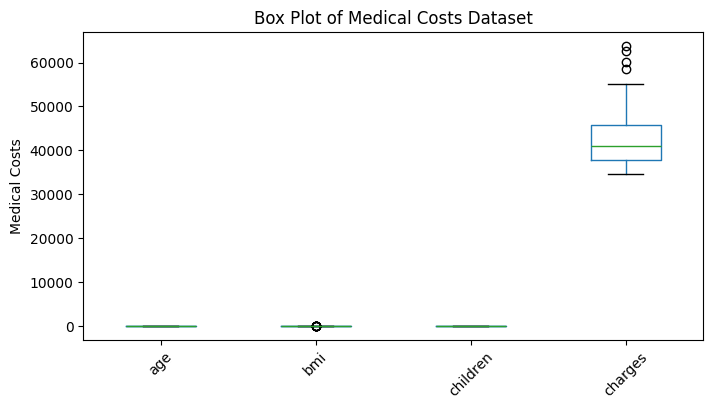

In [ ]:
plt.figure(figsize=(8, 4))
medical_cost_df.boxplot()
plt.title('Box Plot of Medical Costs Dataset')
plt.ylabel('Medical Costs')
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

dataset ready

In [13]:
medical_cost_df.shape

(1337, 7)

##**Exploratory Data Analysis**

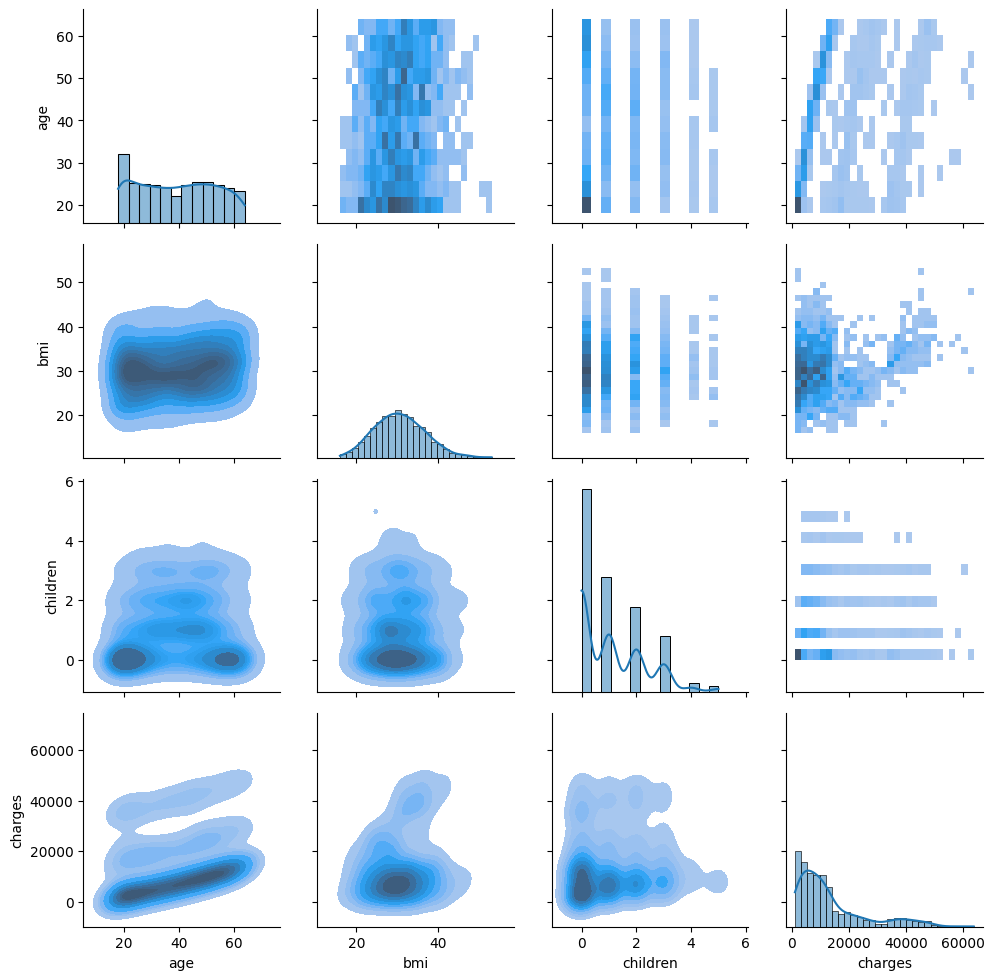

In [14]:
# Approach to visualize the univariate distribution of all variables in a dataset

g = sns.PairGrid(medical_cost_df)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

In [15]:
#Symmetry: Skewness and Kurtosis

def calculate_skewness_kurtosis(medical_cost_df):
    results = {}
    for col in ['charges', 'bmi', 'age']:
        if col in medical_cost_df.columns:
            results[col] = {
                'skewness': skew(medical_cost_df[col].dropna()),
                'kurtosis': kurtosis(medical_cost_df[col].dropna())
            }
        else:
            results[col] = {'skewness': None, 'kurtosis': None}
            print(f"Warning: Column '{col}' not found in DataFrame.")
    return results

In [16]:
calculate_skewness_kurtosis(medical_cost_df)

{'charges': {'skewness': 1.5136902413349014, 'kurtosis': 1.5937433292737193},
 'bmi': {'skewness': 0.2835955670169306, 'kurtosis': -0.05723370910000947},
 'age': {'skewness': 0.054719294607049676, 'kurtosis': -1.2442418566306097}}

Skewness around zero means normality of data. Which is a necessity for LR in ML model.\
Negative kurtosis in 'bmi' and 'age' means data are spread (platykurtic) and positive means data is more concentrated (leptokurtic)

In [17]:
medical_cost_df['charges'].median()

9386.1613

In [18]:
# Frequency tables for nominal variables
def frequency_table(df, column):
    frequencies = df[column].value_counts()
    percentages = (frequencies / len(df)) * 100
    table = pd.DataFrame({'Frequency': frequencies, 'Percentage': percentages})
    return table

# frequency tables
children_freq = frequency_table(medical_cost_df, 'children')
sex_freq = frequency_table(medical_cost_df, 'sex')
smoker_freq = frequency_table(medical_cost_df, 'smoker')
region_freq = frequency_table(medical_cost_df, 'region')


# Concatenate the frequency tables into a single table
frequency_tables = pd.concat([children_freq, sex_freq, smoker_freq, region_freq],
                             keys=['children', 'sex', 'smoker', 'region'], axis=1)

frequency_tables

children                  sex               smoker             \
          Frequency Percentage Frequency Percentage Frequency Percentage   
0             573.0  42.857143       NaN        NaN       NaN        NaN   
1             324.0  24.233358       NaN        NaN       NaN        NaN   
2             240.0  17.950636       NaN        NaN       NaN        NaN   
3             157.0  11.742708       NaN        NaN       NaN        NaN   
4              25.0   1.869858       NaN        NaN       NaN        NaN   
5              18.0   1.346298       NaN        NaN       NaN        NaN   
male            NaN        NaN     675.0  50.486163       NaN        NaN   
female          NaN        NaN     662.0  49.513837       NaN        NaN   
no              NaN        NaN       NaN        NaN    1063.0  79.506358   
yes             NaN        NaN       NaN        NaN     274.0  20.493642   
southeast       NaN        NaN       NaN        NaN       NaN        NaN   
southwest       NaN        NaN       NaN        NaN       NaN        NaN   
northwest       NaN        NaN       NaN        NaN       NaN        NaN   
northeast       NaN        NaN       NaN        NaN       NaN        NaN   

             region             
          Frequency Percentage  
0               NaN        NaN  
1               NaN        NaN  
2               NaN        NaN  
3               NaN        NaN  
4               NaN        NaN  
5               NaN        NaN  
male            NaN        NaN  
female          NaN        NaN  
no              NaN        NaN  
yes             NaN        NaN  
southeast     364.0  27.225131  
southwest     325.0  24.308153  
northwest     324.0  24.233358  
northeast     324.0  24.233358

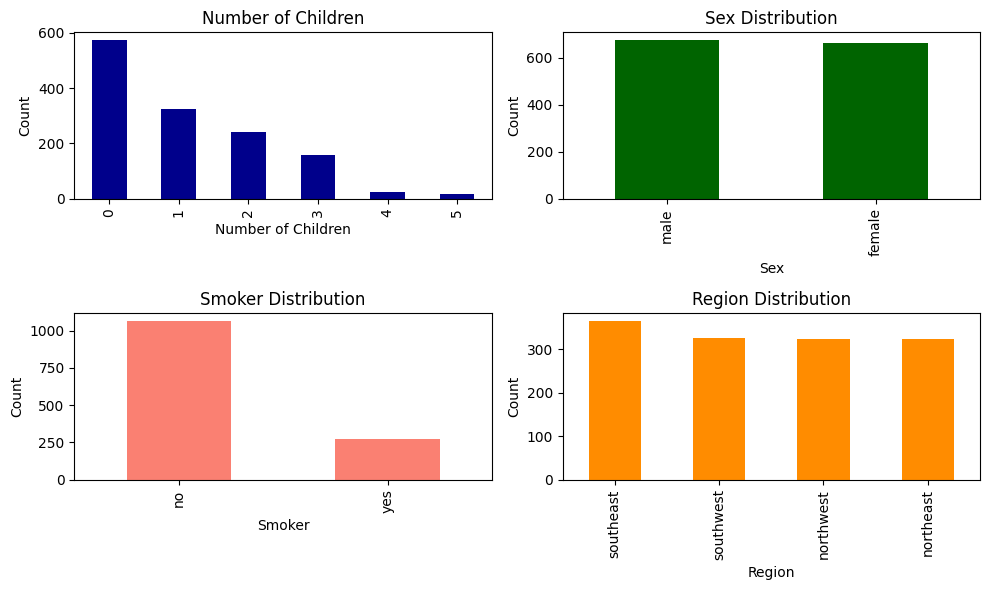

In [19]:
# Frequency graphs of nominal variables
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Children
medical_cost_df['children'].value_counts().plot(kind='bar', ax=axes[0, 0], color='darkblue')
axes[0, 0].set_title('Number of Children')
axes[0, 0].set_xlabel('Number of Children')
axes[0, 0].set_ylabel('Count')

# Sex
medical_cost_df['sex'].value_counts().plot(kind='bar', ax=axes[0, 1], color='darkgreen')
axes[0, 1].set_title('Sex Distribution')
axes[0, 1].set_xlabel('Sex')
axes[0, 1].set_ylabel('Count')

# Smoker
medical_cost_df['smoker'].value_counts().plot(kind='bar', ax=axes[1, 0], color='salmon')
axes[1, 0].set_title('Smoker Distribution')
axes[1, 0].set_xlabel('Smoker')
axes[1, 0].set_ylabel('Count')

# Region
medical_cost_df['region'].value_counts().plot(kind='bar', ax=axes[1, 1], color='darkorange')
axes[1, 1].set_title('Region Distribution')
axes[1, 1].set_xlabel('Region')
axes[1, 1].set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()


Correlations

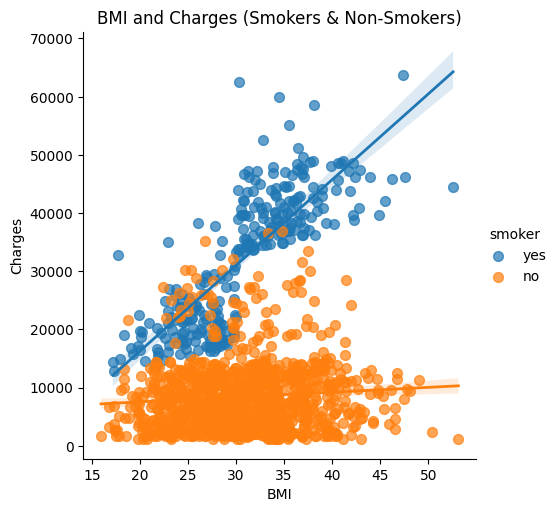

In [20]:
sns.lmplot(
    data=medical_cost_df,
    x='bmi',
    y='charges',
    hue='smoker',
    scatter_kws={'s': 50, 'alpha': 0.7},
    line_kws={"linewidth": 2}
)

# Add plot titles and labels
plt.title("BMI and Charges (Smokers & Non-Smokers)")
plt.xlabel("BMI")
plt.ylabel("Charges")
plt.show()


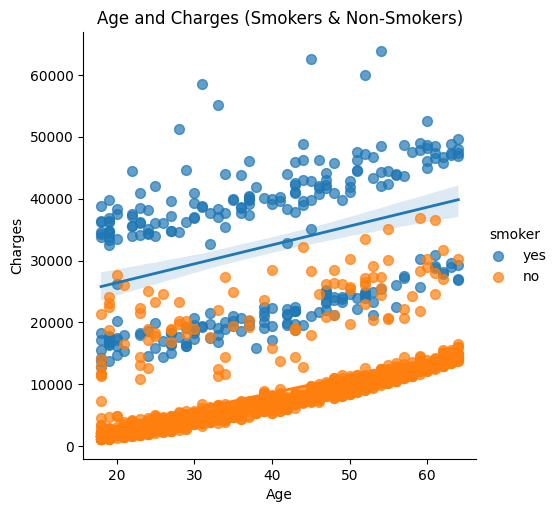

In [21]:
sns.lmplot(
    data=medical_cost_df,
    x='age',
    y='charges',
    hue='smoker',
    scatter_kws={'s': 50, 'alpha': 0.7},
    line_kws={"linewidth": 2}
)

# Add plot titles and labels
plt.title("Age and Charges (Smokers & Non-Smokers)")
plt.xlabel("Age")
plt.ylabel("Charges")
plt.show()

In [22]:
# Calculate the median charges for smokers and non-smokers
smoker_median = medical_cost_df[medical_cost_df['smoker'] == 'yes']['charges'].median()
non_smoker_median = medical_cost_df[medical_cost_df['smoker'] == 'no']['charges'].median()

smoker_median_round = round(smoker_median, 3)
non_smoker_median_round = round(non_smoker_median, 3)

print("Smoker median charge:",smoker_median_round)
print("No smoker median charge:", non_smoker_median_round)

Smoker median charge: 34456.348
No smoker median charge: 7345.727


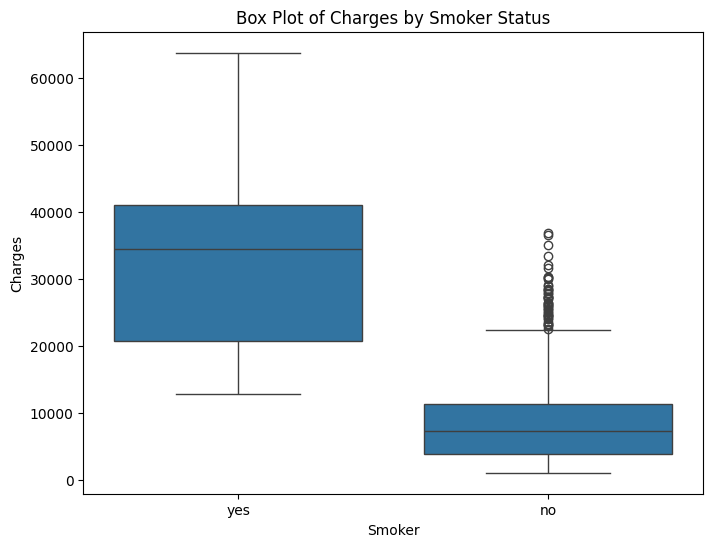

In [24]:
# Box plot charge value between smokers and no smokers

plt.figure(figsize=(8, 6))
sns.boxplot(x='smoker', y='charges', data=medical_cost_df)
plt.title('Box Plot of Charges by Smoker Status')
plt.xlabel('Smoker')
plt.ylabel('Charges')
plt.show()

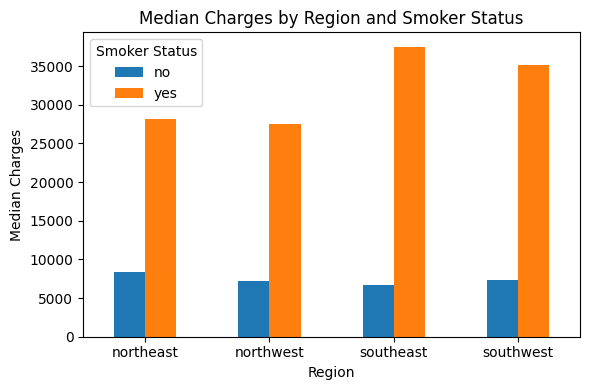

In [25]:
# Charge by region and smoker status
median_charges_by_region = medical_cost_df.groupby(['region', 'smoker'])['charges'].median().unstack()

median_charges_by_region.plot(kind='bar', figsize=(6, 4))
plt.title('Median Charges by Region and Smoker Status')
plt.xlabel('Region')
plt.ylabel('Median Charges')
plt.xticks(rotation=0)
plt.legend(title='Smoker Status')
plt.tight_layout()
plt.show()

##**Data Preprocessing**

In [26]:
# Encoding STEP

# Sex (binary, Label Encoding)
label_encoder = LabelEncoder()
medical_cost_df['sex'] = label_encoder.fit_transform(medical_cost_df['sex'])

# Smoke (binary, Label Encoding)
label_encoder = LabelEncoder()
medical_cost_df['smoker'] = label_encoder.fit_transform(medical_cost_df['smoker'])

# Region (nominal variables, One-Hot Encoding)
medical_cost_df = pd.get_dummies(medical_cost_df, columns=['region'], prefix='region', drop_first=True)

In [27]:
# Standard Scaling (for numerical variables Age, BMI, and Charges)
scaler = StandardScaler()
medical_cost_df[['age', 'bmi']] = scaler.fit_transform(medical_cost_df[['age', 'bmi']])
# Standard Scaling (for numerical variables Age, BMI, and Charges)
scaler = StandardScaler()
medical_cost_df[['age', 'bmi']] = scaler.fit_transform(medical_cost_df[['age', 'bmi']])

In [28]:
# Log transformation (add 1 to avoid log(0) if there are zero values)
medical_cost_df['charges_log'] = np.log(medical_cost_df['charges'] + 1)

# Standard scaling
scaler = StandardScaler()
medical_cost_df['charges_scaled'] = scaler.fit_transform(medical_cost_df[['charges_log']])

In [29]:
medical_cost_df.head()

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest,charges_log,charges_scaled
0,-1.440418,0,-0.453160,0,1,16884.92400,False,False,True,9.734236,0.690627
1,-1.511647,1,0.509422,1,0,1725.55230,False,True,False,7.453882,-1.792857
2,-0.799350,1,0.383155,3,0,4449.46200,False,True,False,8.400763,-0.761629
3,-0.443201,1,-1.305052,0,0,21984.47061,True,False,False,9.998137,0.978037
4,-0.514431,1,-0.292456,0,0,3866.85520,True,False,False,8.260455,-0.914435


In [30]:
# Handling NaN values of 'charges'

nan_sum = medical_cost_df['charges'].isna().sum()
print(f"Sum of NaN values in 'charges' column: {nan_sum}")

Sum of NaN values in 'charges' column: 0


In [31]:
print(medical_cost_df['charges'].min())

1121.8739


In [32]:
medical_cost_df['charges'] = medical_cost_df['charges'].apply(lambda x: x if x > 0 else 1)
medical_cost_df['charges_log'] = medical_cost_df['charges_log'].apply(lambda x: x if x > 0 else 1)
medical_cost_df['charges_scaled'] = medical_cost_df['charges_scaled'].apply(lambda x: x if x > 0 else 1)

In [33]:
print(medical_cost_df['charges_log'].isnull().sum())

0


In [34]:
# Standard scaling after log transformation
scaler = StandardScaler()
medical_cost_df['charges_scaled'] = scaler.fit_transform(medical_cost_df[['charges_log']])

In [35]:
medical_cost_df.head()

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest,charges_log,charges_scaled
0,-1.440418,0,-0.453160,0,1,16884.92400,False,False,True,9.734236,0.690627
1,-1.511647,1,0.509422,1,0,1725.55230,False,True,False,7.453882,-1.792857
2,-0.799350,1,0.383155,3,0,4449.46200,False,True,False,8.400763,-0.761629
3,-0.443201,1,-1.305052,0,0,21984.47061,True,False,False,9.998137,0.978037
4,-0.514431,1,-0.292456,0,0,3866.85520,True,False,False,8.260455,-0.914435


<Axes: >

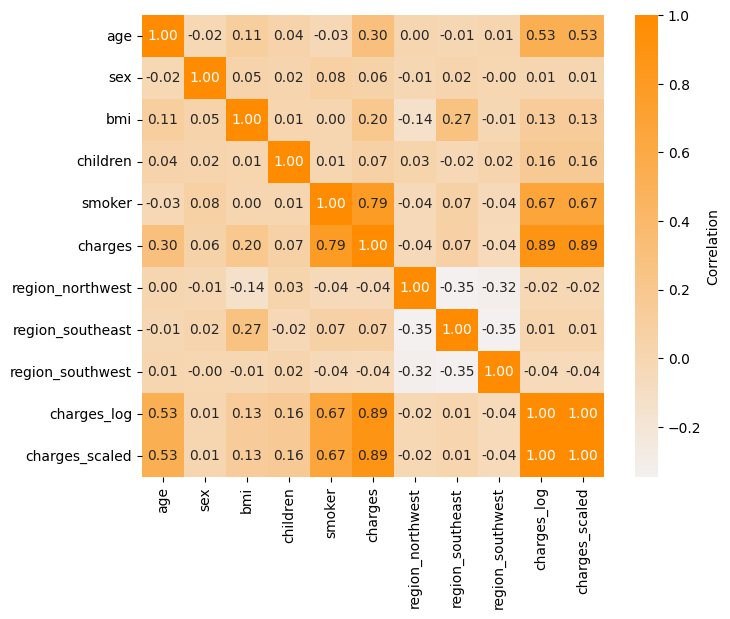

In [36]:
# Matrix correlation

medical_cost_df.corr()['charges'].sort_values()

f, ax = plt.subplots(figsize=(8, 6))
corr = medical_cost_df.corr()
sns.heatmap(corr,
            mask=np.zeros_like(corr, dtype=bool),
            cmap=sns.light_palette("darkorange", as_cmap=True),
            square=True,
            ax=ax,
            annot=True,
            fmt=".2f",
            cbar_kws={'label': 'Correlation'})

In [37]:
medical_cost_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1337 non-null   float64
 1   sex               1337 non-null   int64  
 2   bmi               1337 non-null   float64
 3   children          1337 non-null   int64  
 4   smoker            1337 non-null   int64  
 5   charges           1337 non-null   float64
 6   region_northwest  1337 non-null   bool   
 7   region_southeast  1337 non-null   bool   
 8   region_southwest  1337 non-null   bool   
 9   charges_log       1337 non-null   float64
 10  charges_scaled    1337 non-null   float64
dtypes: bool(3), float64(5), int64(3)
memory usage: 97.9 KB


In [38]:
medical_cost_df.describe()

,age,sex,bmi,children,smoker,charges,charges_log,charges_scaled
count,1.337000e+03,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1.337000e+03
mean,-1.594337e-17,0.504862,0.000000,1.095737,0.204936,13279.121487,9.100097,1.621573e-15
std,1.000374e+00,0.500163,1.000374,1.205571,0.403806,12110.359656,0.918551,1.000374e+00
min,-1.511647e+00,0.000000,-2.411119,0.000000,0.000000,1121.873900,7.023647,-2.261417e+00
25%,-8.705798e-01,0.000000,-0.717173,0.000000,0.000000,4746.344000,8.465341,-6.912990e-01
50%,-1.582291e-02,1.000000,-0.043202,1.000000,0.000000,9386.161300,9.147098,5.118854e-02
75%,8.389340e-01,1.000000,0.661926,2.000000,0.000000,16657.717450,9.720689,6.758739e-01
max,1.764921e+00,1.000000,3.684136,5.000000,1.000000,63770.428010,11.063061,2.137822e+00


##**Training and Test split**

In [39]:
X = medical_cost_df.drop('charges',axis=1) # Independet variable
y = medical_cost_df['charges'] # dependent variable

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=23)

#**Model Building**

In [40]:
X = medical_cost_df.drop(columns=['charges'])
y = medical_cost_df['charges']
feature_names = X.columns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

# Perform feature selection using SelectFromModel
selector = SelectFromModel(lasso, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Print the names of selected features
selected_feature_names = [feature_names[i] for i, selected in enumerate(selector.get_support()) if selected]
print("Selected Feature Names:", selected_feature_names)

# Train a linear regression model on the selected features
model = LinearRegression()
model.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_selected)

# Calculate the mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)

Selected Feature Names: ['age', 'sex', 'bmi', 'children', 'smoker', 'region_northwest', 'region_southeast', 'region_southwest', 'charges_log', 'charges_scaled']
Root Mean Squared Error: 4555.247702670423
R2 Score: 0.8870770238741993


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


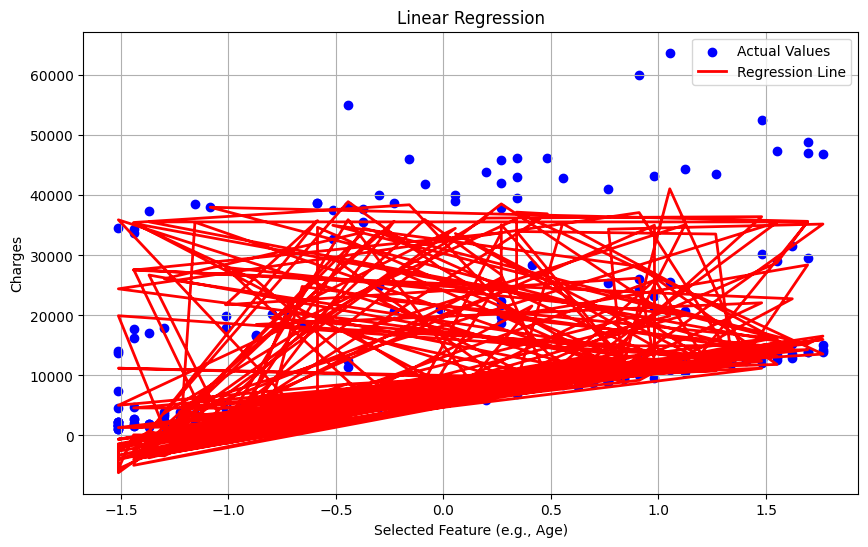

In [41]:
# prompt: linear regression grah to show my model

import matplotlib.pyplot as plt

# Assuming X_test_selected and y_pred are defined from your previous code
# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(X_test_selected[:, 0], y_test, color='blue', label='Actual Values') # Assuming the first selected feature
plt.plot(X_test_selected[:, 0], y_pred, color='red', linewidth=2, label='Regression Line')
plt.xlabel('Selected Feature (e.g., Age)') # Replace with your actual feature name
plt.ylabel('Charges')
plt.title('Linear Regression')
plt.legend()
plt.grid(True)
plt.show()